table of contents  
1. Prepare  
2. Data Read, Preprocess, EDA  
3. Aggregate, Visualize

# Prepare

## Import Library

In [1]:
import os, time, sys, importlib
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Define Static Parameter

In [2]:
base_dir = os.path.join('..')
data_dir = os.path.join(base_dir, 'datasets', 'positional_data')

sys.path.append(os.path.join(base_dir,'..','LaurieOnTracking','src'))
import Metrica_IO as mio
import Metrica_Viz as mviz
import Metrica_Velocities as mvel

# Data Read Preprocess, EDA

## Read Dataset

In [3]:
os.listdir(data_dir)

['LIV_[2]-1_CHE.csv',
 'liverpool_2019_passes.csv',
 'liverpool_2019.csv',
 'Real_vs_Barcelona_Calma.csv']

In [4]:
df = pd.read_csv(os.path.join(data_dir, 'liverpool_2019.csv'), index_col=['play', 'frame'])

## interpolate player_num

In [5]:
df['player_num'] = df[['player', 'player_num']].apply(lambda xs: xs[0] if np.isnan(xs[1]) else xs[1], axis=1)

In [6]:
df = df.astype({'player_num':int})

In [7]:
df.head()

Unnamed: 0 bgcolor        dx        dy  \
play                          frame                                           
Liverpool [3] - 0 Bournemouth 0               0     NaN  0.000000  0.000000   
                              1               1     NaN  0.185745  1.217580   
                              2               2     NaN  0.178659  1.171133   
                              3               3     NaN  0.171573  1.124685   
                              4               4     NaN  0.164488  1.078238   

                                    edgecolor  player  player_num team  \
play                          frame                                      
Liverpool [3] - 0 Bournemouth 0           NaN       0           0  NaN   
                              1           NaN       0           0  NaN   
                              2           NaN       0           0  NaN   
                              3           NaN       0           0  NaN   
                              4           NaN       0           0  NaN   

                                             x          y    z  
play                          frame                             
Liverpool [3] - 0 Bournemouth 0      46.394558  11.134454  0.0  
                              1      46.580302  12.352034  0.0  
                              2      46.758961  13.523166  0.0  
                              3      46.930535  14.647852  0.0  
                              4      47.095022  15.726090  0.0

In [8]:
df.index.get_level_values('play').unique()

Index(['Liverpool [3] - 0 Bournemouth', 'Bayern 0 - [1] Liverpool',
       'Fulham 0 - [1] Liverpool', 'Southampton 1 - [2] Liverpool',
       'Liverpool [2] - 0 Porto', 'Porto 0 - [2] Liverpool',
       'Liverpool [4] - 0 Barcelona', 'Liverpool [1] - 0 Wolves',
       'Liverpool [3] - 0 Norwich', 'Liverpool [2] - 1 Chelsea',
       'Liverpool [2] - 1 Newcastle', 'Liverpool [2] - 0 Salzburg',
       'Genk 0 - [3] Liverpool', 'Liverpool [2] - 0 Man City',
       'Liverpool [1] - 0 Everton', 'Liverpool [2] - 0 Everton',
       'Bournemouth 0 - 3 Liverpool', 'Liverpool [1] - 0 Watford',
       'Leicester 0 - [3] Liverpool'],
      dtype='object', name='play')

## Viz All

In [9]:
n_player = 11

def compute_stretch_index(tracking_df):
    stretch_index_list = []
    c_list = [c for c in tracking_df.columns.tolist() if not c.startswith('ball_')]
    n_player = int(len(c_list)/2)
    for i in tqdm(tracking_df.index[:]):
        tracking_array = tracking_df[tracking_df.index==i][c_list].values.reshape(-1).reshape(n_player,2)

        stretch_index = np.mean(np.linalg.norm(tracking_array - tracking_array.mean(axis=0), axis=1))
        stretch_index_list.append(stretch_index)

    tracking_df['stretch_index'] = stretch_index_list

    return tracking_df

In [10]:
x_size, y_size = 106, 68
fps = 20

def pivot_table_for_Metrica(df):
    df = df.pivot_table(index='frame', columns='player_num', values=['x', 'y'])
    df.columns = [f'ball_{c_tuple[0]}' if c_tuple[1] == 0 else f'{c_tuple[1]}_{c_tuple[0]}' for c_tuple in df.columns]

    c_x_list, c_y_list = [c for c in df.columns if c.endswith('_x')], [c for c in df.columns if c.endswith('_y')]
    
    df[c_x_list] = df[c_x_list].applymap(lambda x: (x_size/2)*((x-50)/50))
    df[c_y_list] = df[c_y_list].applymap(lambda x: (y_size/2)*((x-50)/50))
    
    df = compute_stretch_index(df)

    df['Time [s]'] = np.arange(0, (len(df)+1)/fps, 1/fps)[:len(df)]
    df = mvel.calc_player_velocities(df, filter_='moving average', data_type='liverpool')
    
    return df

In [11]:
df_dict = dict()
for play in df.index.get_level_values('play').unique():
    df_tmp = df.loc[play]
    bgcolor_list = df_tmp.bgcolor.dropna().unique().tolist()
    
    # split, preprocess
    df_dict[play] = dict()
    df_dict[play]['dfs'] = [pivot_table_for_Metrica(df_tmp[df_tmp.bgcolor.isin([bgcolor, np.nan])]) for bgcolor in bgcolor_list]
    df_dict[play]['colors'] = bgcolor_list

100%|██████████| 125/125 [00:00<00:00, 920.93it/s]


# Aggregate, Visualize

In [12]:
twitter_color = "#141d26"

def set_tone(ax):
    # remove axis labels and ticks
    ax.spines['left'].set_color('w'); ax.tick_params(axis='y', colors='w'); ax.xaxis.label.set_color('w')
    ax.spines['bottom'].set_color('w'); ax.tick_params(axis='x', colors='w'); ax.yaxis.label.set_color('w')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_facecolor(twitter_color)

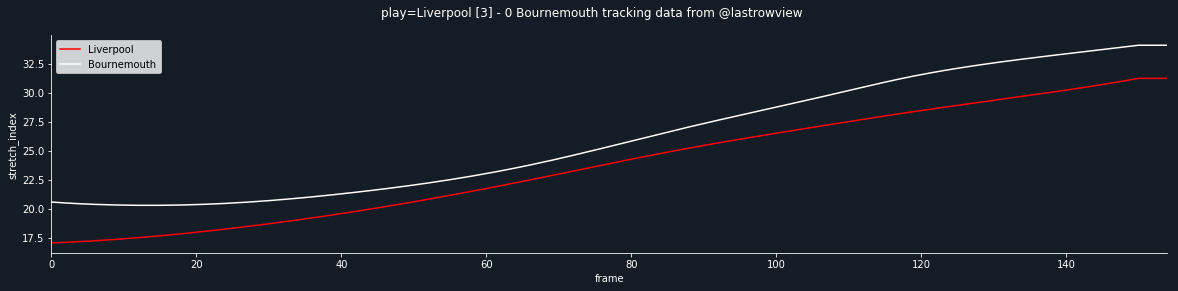

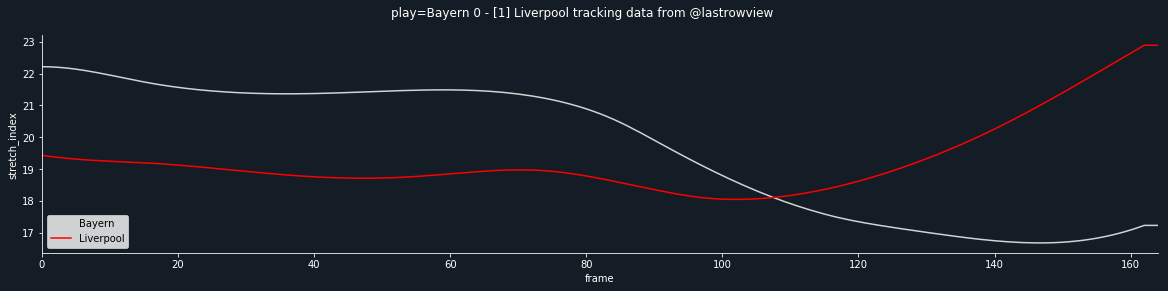

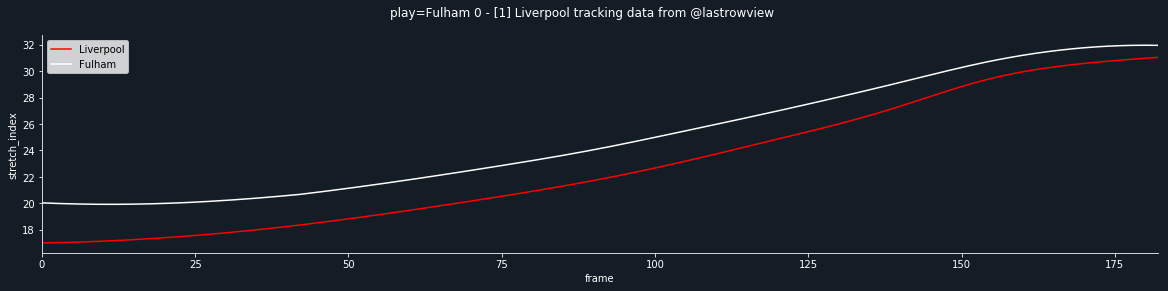

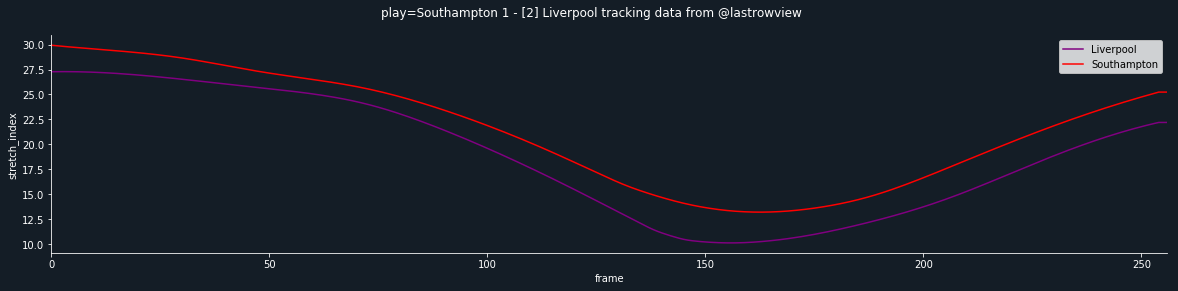

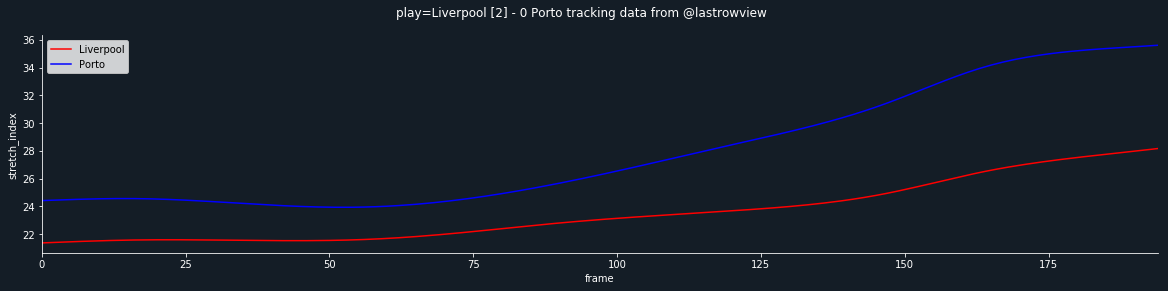

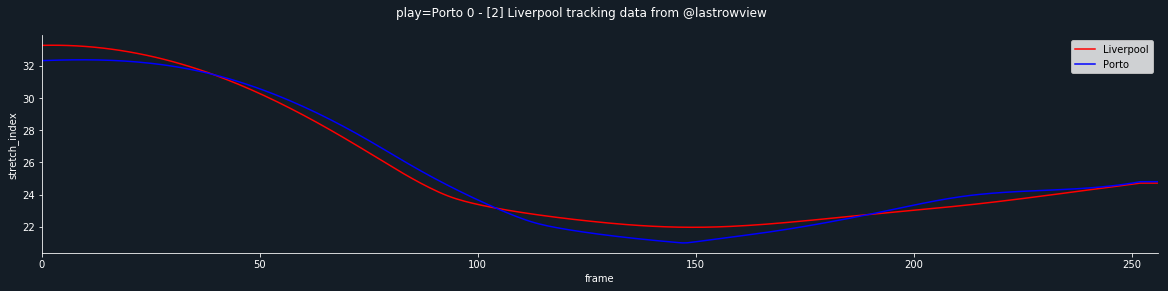

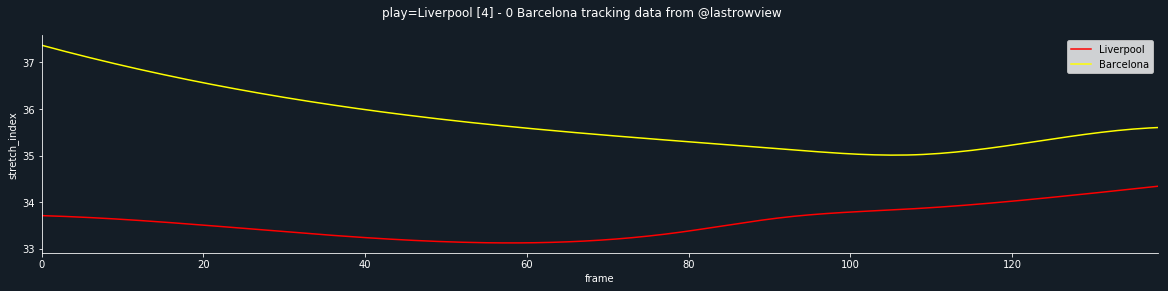

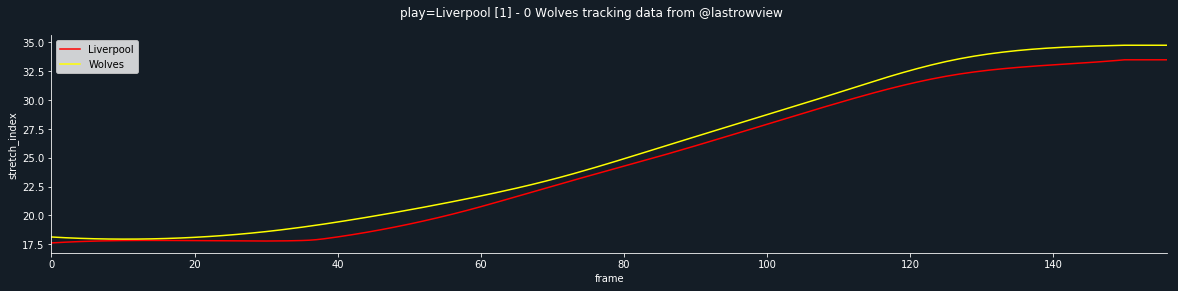

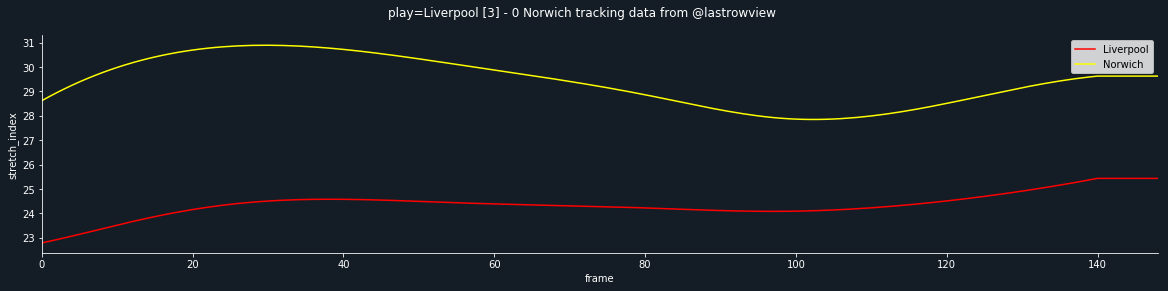

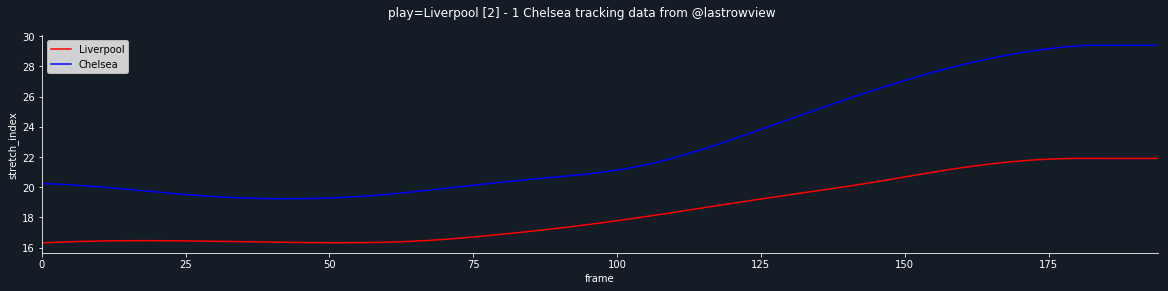

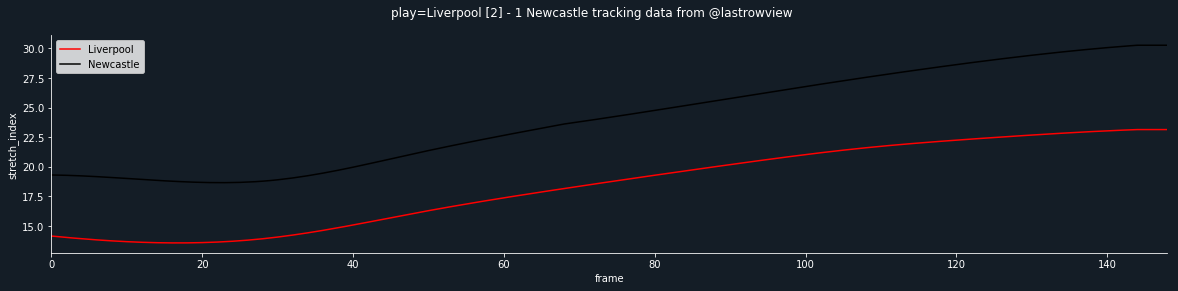

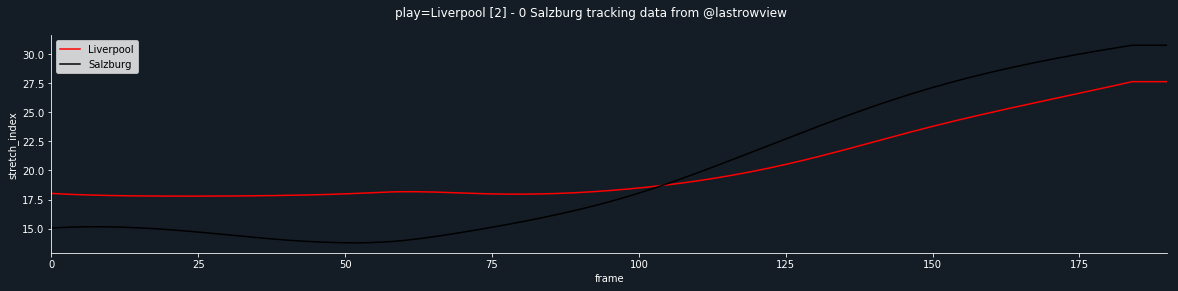

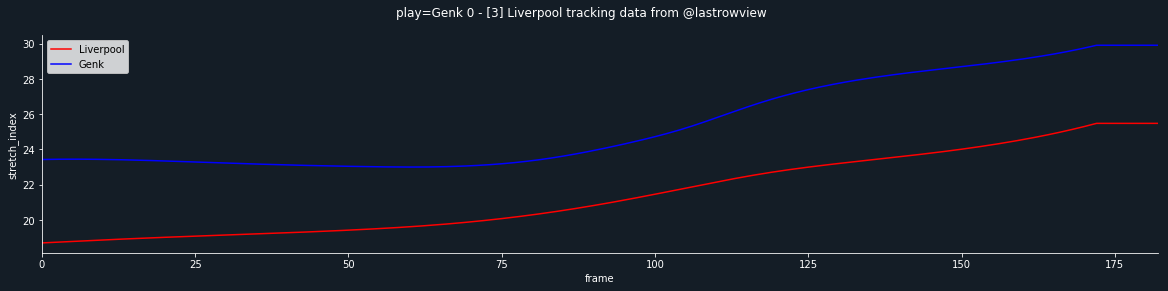

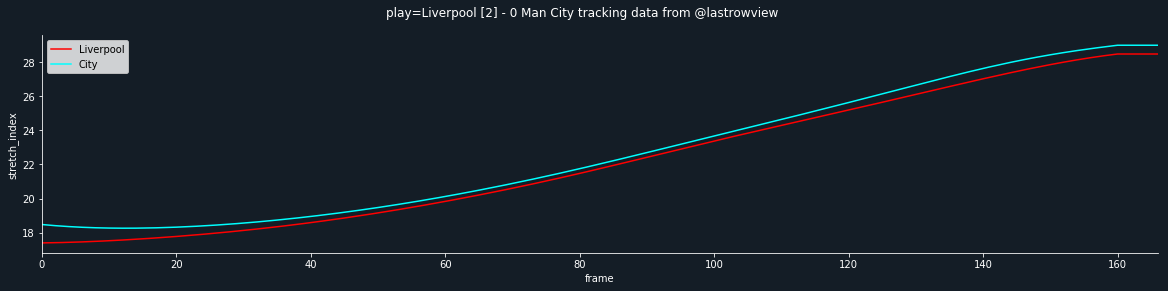

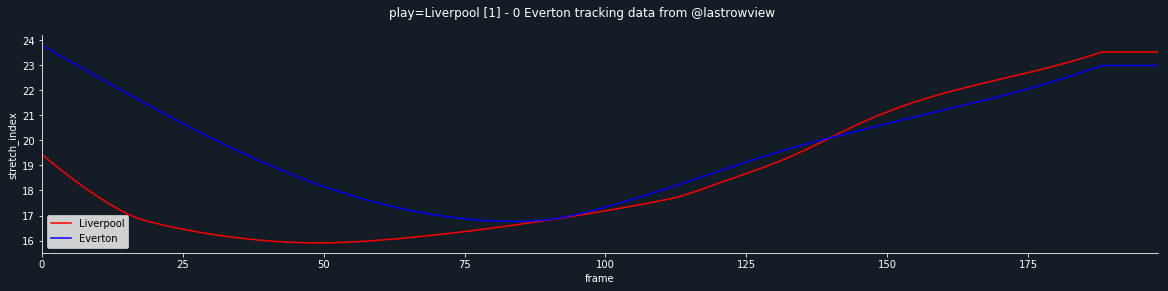

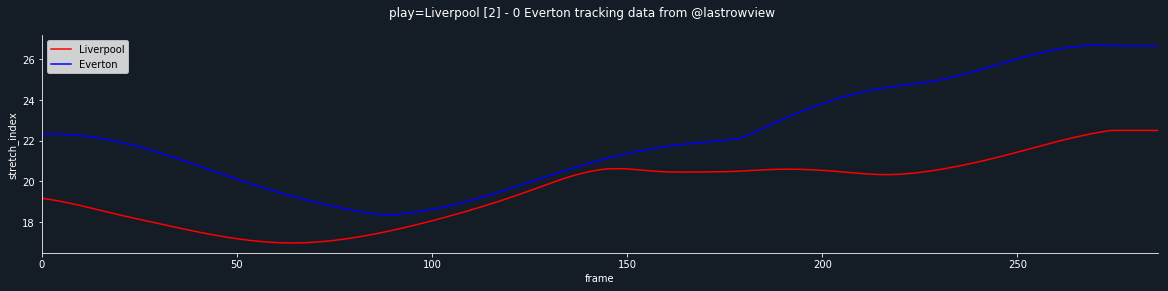

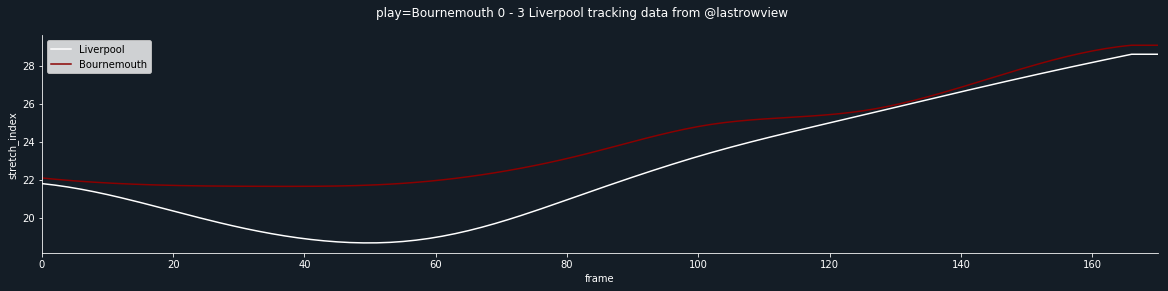

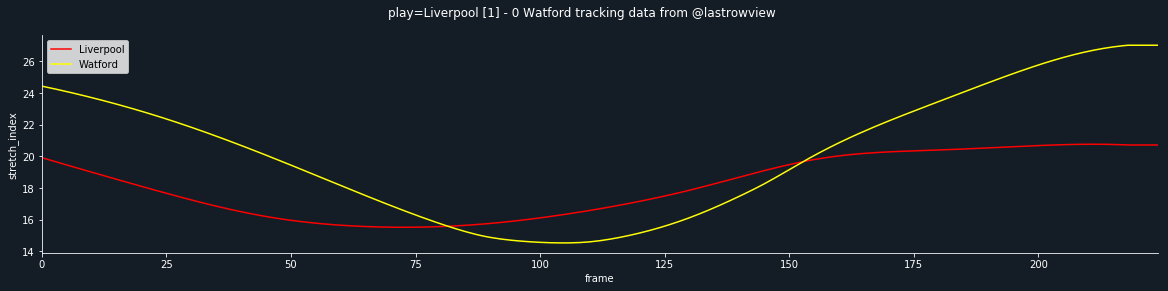

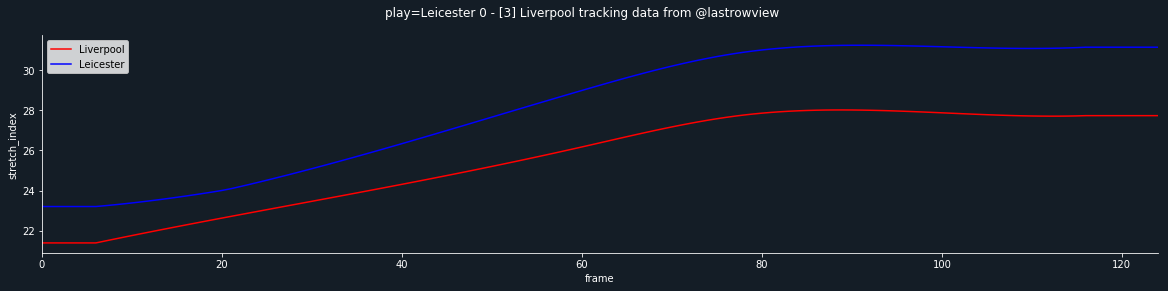

In [13]:
c_value = 'stretch_index'
team_list = []
for play, data_dict in df_dict.items():
    
    team_list = np.array(play.split(' '))[[0,-1]].tolist()
    team_list.remove('Liverpool')
    another_team = team_list[0]
    team_list = [another_team, 'Liverpool'] if another_team == 'Bayern' else ['Liverpool', another_team]
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 4), sharey=True)
    set_tone(ax)
    

    for team, color, df in zip(team_list, data_dict['colors'], data_dict['dfs']):
        df.plot(y=c_value, ax=ax, label=team, color=color)
        
    ax.set_ylabel(c_value, color='w')

    fig.patch.set_facecolor(twitter_color)
    fig.suptitle(f'play={play} tracking data from @lastrowview', color='w')
    plt.savefig(os.path.join('..','reports','figure',f'play={play}_stretch_index.png'), bbox_inches='tight', facecolor=twitter_color)

In [14]:
twitter_color = "#141d26"

def plot_pitch( field_dimen = (106.0,68.0), field_color ='green', linewidth=2, markersize=20):
    """ plot_pitch
    
    Plots a soccer pitch. All distance units converted to meters.
    
    Parameters
    -----------
        field_dimen: (length, width) of field in meters. Default is (106,68)
        field_color: color of field. options are {'green','white'}
        linewidth  : width of lines. default = 2
        markersize : size of markers (e.g. penalty spot, centre spot, posts). default = 20
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    fig,axes = plt.subplots(nrows=2, ncols=1, gridspec_kw={'height_ratios':[2,1]}, figsize=(12,12)) # create a figure 
    # decide what color we want the field to be. Default is green, but can also choose white
    for ax in axes:
        if field_color=='green':
            ax.set_facecolor('mediumseagreen')
            fig.patch.set_facecolor('mediumseagreen')
            lc = 'whitesmoke' # line color
            pc = 'w' # 'spot' colors
        elif field_color=='white':
            lc = 'k'
            pc = 'k'
        elif field_color=='twitter_dark_mode':
            ax.set_facecolor(twitter_color)
            fig.patch.set_facecolor(twitter_color)
            lc = 'whitesmoke'
            pc = 'w'
        else:
            print(f'{field_color} does not exist in setting...')
            exit()

    ax = axes[0]
    # ALL DIMENSIONS IN m
    border_dimen = (3,3) # include a border arround of the field of width 3m
    meters_per_yard = 0.9144 # unit conversion from yards to meters
    half_pitch_length = field_dimen[0]/2. # length of half pitch
    half_pitch_width = field_dimen[1]/2. # width of half pitch
    signs = [-1,1] 
    # Soccer field dimensions typically defined in yards, so we need to convert to meters
    goal_line_width = 8*meters_per_yard
    box_width = 20*meters_per_yard
    box_length = 6*meters_per_yard
    area_width = 44*meters_per_yard
    area_length = 18*meters_per_yard
    penalty_spot = 12*meters_per_yard
    corner_radius = 1*meters_per_yard
    D_length = 8*meters_per_yard
    D_radius = 10*meters_per_yard
    D_pos = 12*meters_per_yard
    centre_circle_radius = 10*meters_per_yard
    # plot half way line # center circle
    ax.plot([0,0],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
    ax.scatter(0.0,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
    y = np.linspace(-1,1,50)*centre_circle_radius
    x = np.sqrt(centre_circle_radius**2-y**2)
    ax.plot(x,y,lc,linewidth=linewidth)
    ax.plot(-x,y,lc,linewidth=linewidth)
    for s in signs: # plots each line seperately
        # plot pitch boundary
        ax.plot([-half_pitch_length,half_pitch_length],[s*half_pitch_width,s*half_pitch_width],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length],[-half_pitch_width,half_pitch_width],lc,linewidth=linewidth)
        # goal posts & line
        ax.plot( [s*half_pitch_length,s*half_pitch_length],[-goal_line_width/2.,goal_line_width/2.],pc+'s',markersize=6*markersize/20.,linewidth=linewidth)
        # 6 yard box
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[box_width/2.,box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*box_length],[-box_width/2.,-box_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*box_length,s*half_pitch_length-s*box_length],[-box_width/2.,box_width/2.],lc,linewidth=linewidth)
        # penalty area
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[area_width/2.,area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length,s*half_pitch_length-s*area_length],[-area_width/2.,-area_width/2.],lc,linewidth=linewidth)
        ax.plot([s*half_pitch_length-s*area_length,s*half_pitch_length-s*area_length],[-area_width/2.,area_width/2.],lc,linewidth=linewidth)
        # penalty spot
        ax.scatter(s*half_pitch_length-s*penalty_spot,0.0,marker='o',facecolor=lc,linewidth=0,s=markersize)
        # corner flags
        y = np.linspace(0,1,50)*corner_radius
        x = np.sqrt(corner_radius**2-y**2)
        ax.plot(s*half_pitch_length-s*x,-half_pitch_width+y,lc,linewidth=linewidth)
        ax.plot(s*half_pitch_length-s*x,half_pitch_width-y,lc,linewidth=linewidth)
        # draw the D
        y = np.linspace(-1,1,50)*D_length # D_length is the chord of the circle that defines the D
        x = np.sqrt(D_radius**2-y**2)+D_pos
        ax.plot(s*half_pitch_length-s*x,y,lc,linewidth=linewidth)
        
    # remove axis labels and ticks
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    # set axis limits
    xmax = field_dimen[0]/2. + border_dimen[0]
    ymax = field_dimen[1]/2. + border_dimen[1]
    ax.set_xlim([-xmax,xmax])
    ax.set_ylim([-ymax,ymax])
    ax.set_axisbelow(True)

    set_tone(axes[1])
    
    return fig, axes

In [15]:
import matplotlib.animation as animation
def save_match_clip(hometeam, awayteam, fpath, fname='clip_test', figax=None, frames_per_second=25, team_names=['Home', 'Away'], team_colors=('r','b'), field_dimen = (106.0,68.0), annotate=True, include_player_velocities=True, PlayerMarkerSize=10, PlayerAlpha=0.7):
    """ save_match_clip( hometeam, awayteam, fpath )
    
    Generates a movie from Metrica tracking data, saving it in the 'fpath' directory with name 'fname'
    
    Parameters
    -----------
        hometeam: home team tracking data DataFrame. Movie will be created from all rows in the DataFrame
        awayteam: away team tracking data DataFrame. The indices *must* match those of the hometeam DataFrame
        fpath: directory to save the movie
        fname: movie filename. Default is 'clip_test.mp4'
        fig,ax: Can be used to pass in the (fig,ax) objects of a previously generated pitch. Set to (fig,ax) to use an existing figure, or None (the default) to generate a new pitch plot,
        frames_per_second: frames per second to assume when generating the movie. Default is 25.
        team_colors: Tuple containing the team colors of the home & away team. Default is 'r' (red, home team) and 'b' (blue away team)
        field_dimen: tuple containing the length and width of the pitch in meters. Default is (106,68)
        include_player_velocities: Boolean variable that determines whether player velocities are also plotted (as quivers). Default is False
        PlayerMarkerSize: size of the individual player marlers. Default is 10
        PlayerAlpha: alpha (transparency) of player markers. Defaault is 0.7
        
    Returrns
    -----------
       fig,ax : figure and aixs objects (so that other data can be plotted onto the pitch)

    """
    # check that indices match first
    assert np.all( hometeam.index==awayteam.index ), "Home and away team Dataframe indices must be the same"
    # in which case use home team index
    index = hometeam.index
    # Set figure and movie settings
    FFMpegWriter = animation.writers['ffmpeg']
    metadata = dict(title='Tracking Data', artist='Matplotlib', comment='Metrica tracking data clip')
    writer = FFMpegWriter(fps=frames_per_second, metadata=metadata)
    fname = fpath + '/' +  fname + '.mp4' # path and filename
    # create football pitch
    if figax is None:
        fig,axes = plot_pitch(field_dimen=field_dimen)
    else:
        fig,axes = figax
    fig.set_tight_layout(True)
    for (df, team, color) in zip([hometeam, awayteam], team_names, team_colors):
        axes[1].plot(df.index.tolist(), df.stretch_index.tolist(), c=color, label=team)
    axes[1].set_ylabel('stretch_index', color='w')
    ylim = axes[1].get_ylim()
    # Generate movie
    print("Generating movie...",end='')
    with writer.saving(fig, fname, 100):
        for i in index:
            figobjs = [] # this is used to collect up all the axis objects so that they can be deleted after each iteration
            ax = axes[0]
            for team,color in zip( [hometeam.loc[i],awayteam.loc[i]], team_colors) :
                x_columns = [c for c in team.keys() if c[-2:].lower()=='_x' and c!='ball_x'] # column header for player x positions
                y_columns = [c for c in team.keys() if c[-2:].lower()=='_y' and c!='ball_y'] # column header for player y positions
                objs, = ax.plot( team[x_columns], team[y_columns], color=color, linestyle='None', marker='o', MarkerSize=PlayerMarkerSize, alpha=PlayerAlpha ) # plot player positions
                figobjs.append(objs)
                if include_player_velocities:
                    vx_columns = ['{}_vx'.format(c[:-2]) for c in x_columns] # column header for player x positions
                    vy_columns = ['{}_vy'.format(c[:-2]) for c in y_columns] # column header for player y positions
                    objs = ax.quiver( team[x_columns], team[y_columns], team[vx_columns], team[vy_columns], color=color, scale_units='inches', scale=10.,width=0.0015,headlength=5,headwidth=3,alpha=PlayerAlpha)
                    figobjs.append(objs)
                if annotate:
                    figobjs += [ax.text( team[x]+0.5, team[y]+0.5, x.split('_')[0], fontsize=10, color=color) for x,y in zip(x_columns,y_columns) if not (np.isnan(team[x]) or np.isnan(team[y]))]
            # plot ball
            objs, = ax.plot( team['ball_x'], team['ball_y'], color='yellow', marker='o', MarkerSize=6, alpha=1.0, LineWidth=0)
            figobjs.append(objs)
            
            # plot stretch Index
            objs, = axes[1].plot([i, i], ylim, color='w')
            figobjs.append(objs)

            ax = axes[0]
            # include match time at the top
            frame_minute =  int( team['Time [s]']/60. )
            frame_second =  ( team['Time [s]']/60. - frame_minute ) * 60.
            timestring = "%d:%1.2f" % ( frame_minute, frame_second  )
            objs = ax.text(-2.5,field_dimen[1]/2.+1., timestring, fontsize=14, color='w')
            figobjs.append(objs)
            writer.grab_frame()
            # Delete all axis objects (other than pitch lines) in preperation for next frame
            for figobj in figobjs:
                figobj.remove()
    print("done")
    plt.clf()
    plt.close(fig)

In [16]:
for play, data_dict in df_dict.items():
    
    team_list = np.array(play.split(' '))[[0,-1]].tolist()
    team_list.remove('Liverpool')
    another_team = team_list[0]
    team_list = [another_team, 'Liverpool'] if another_team == 'Bayern' else ['Liverpool', another_team]
    
    bgcolor_list, df_list = data_dict['colors'], data_dict['dfs']
    save_match_clip(df_list[0], df_list[1], 
                    frames_per_second=20, fpath=os.path.join(base_dir, 'reports', 'movie', 'stretch_annotated'), fname=play, 
                    figax=plot_pitch(field_color='twitter_dark_mode'), team_names=team_list, team_colors=bgcolor_list)

Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done


In [17]:
for play, data_dict in df_dict.items():
    
    team_list = np.array(play.split(' '))[[0,-1]].tolist()
    team_list.remove('Liverpool')
    another_team = team_list[0]
    team_list = [another_team, 'Liverpool'] if another_team == 'Bayern' else ['Liverpool', another_team]
    
    bgcolor_list, df_list = data_dict['colors'], data_dict['dfs']
    save_match_clip(df_list[0], df_list[1], 
                    frames_per_second=20, fpath=os.path.join(base_dir, 'reports', 'movie', 'stretch'), fname=play, 
                    figax=plot_pitch(field_color='twitter_dark_mode'), team_names=team_list, team_colors=bgcolor_list, 
                    annotate=False, include_player_velocities=False)

Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done
Generating movie...done


## write preprocessed data

In [21]:
for play, data_dict in df_dict.items():
    team_list = np.array(play.split(' '))[[0,-1]].tolist()
    team_list.remove('Liverpool')
    another_team = team_list[0]
    team_list = [another_team, 'Liverpool'] if another_team == 'Bayern' else ['Liverpool', another_team]
    
    bgcolor_list, df_list = data_dict['colors'], data_dict['dfs']
    
    out_dir = os.path.join(base_dir, 'datasets', 'preprocessed', play)
    if not os.path.exists(out_dir):
        os.mkdir(out_dir)
    for team, bgcolor, df in zip(team_list, bgcolor_list, df_list):
        c_list = [c for c in df.columns if c.split('_')[-1] in ['x', 'y', 'vx', 'vy']] + ['Time [s]']
        df[c_list].to_csv(os.path.join(out_dir, f'{team}_{bgcolor}.csv'))